In [5]:
import numpy as np
import argparse
import time
# The mnist library is from https://gist.github.com/akesling/5358964 and provides functions to 
# read MNIST into numpy arrays for processing.
from mnist import read, show

In [6]:
# read array of tuples of arrays
training_data_orig = list(read(dataset='training', path='.'))

./train-images-idx3-ubyte


In [7]:
# reads and binarizes 500 images
training_data = training_data_orig[:500]
labels, imgs = zip(*training_data)
training_binarized = (np.array(imgs)/255 > 0.5).astype(int)
training_binarized = training_binarized*2 - 1

In [8]:
# introduces 2% noise into each binarized image
training_noisy = np.copy(training_binarized)
# flip 16 values in each image
for i in range(len(training_binarized)):
    for count in range(16):
        row = np.random.randint(0,28)
        col = np.random.randint(0,28)
        training_noisy[i][row][col] = -1 * training_binarized[i][row][col]

In [9]:
theta_hi_xj = 2
theta_hi_hj = 0.2
def boltzmann(img, c):
    res = np.random.rand(28,28) # Random initial values of pi
    for a in range(20): # Requires at most 20 iterations based on testing of differences (17 in the worst case)
        for i in range(len(img)):
            for j in range(len(img[0])):
                # Calculates values used in calculation of pi using passed in value of c for weighting of neighbors
                inner = 0
                if j > 0:
                    inner += c*(2*res[i][j-1] - 1) + theta_hi_xj*img[i][j-1]

                if j < len(img[0])-1:
                    inner += c*(2*res[i][j+1] - 1) + theta_hi_xj*img[i][j+1]

                if i > 0:
                    inner += c*(2*res[i-1][j] - 1) + theta_hi_xj*img[i-1][j]

                if i < len(img)-1:
                    inner += c*(2*res[i+1][j] - 1) + theta_hi_xj*img[i+1][j]

                res[i][j] = np.exp(inner) / (np.exp(-1*inner) + np.exp(inner))

    return res # table of pi probabilities

In [10]:
# Used for the parallel processing of multiple c values at once
def boltzmann_parallel(imgs, c):
    result = np.empty(np.shape(training_noisy))
    for i in range(len(result)):
        result[i] = boltzmann(imgs[i], c)
    return result

In [15]:
# Denoise all 500 images in parallel
from multiprocessing import Process, Pool
pool = Pool(7)
results_array = pool.starmap(boltzmann_parallel, [(training_binarized, -1),(training_binarized, -0.6),(training_binarized, -0.2),(training_binarized, 0),(training_binarized, 0.2),(training_binarized, 0.6),(training_binarized, 1)])
# results array = denoised images with values of c= -1, -0.6, -0.2, 0, 0.2(default), 0.6, 1


In [16]:
# Binarize denoised images
training_denoised_bin = np.empty(np.shape(training_noisy)) # For the default c = 0.2 case
results_bin = np.empty(np.shape(results_array)) # For everything else
for n in range(len(results_array)): # For each c value
    for i in range(len(results_array[n])): # For each of 500 images
        for row in range(len(results_array[n][i])):
            for col in range(len(results_array[n][i][0])):
                
                if results_array[n][i][row][col] > 0.5: # Threshold is 0.5, greater is a black pixel
                    training_denoised_bin[i][row][col] = 1
                    results_bin[n][i][row][col] = 1
                else:
                    training_denoised_bin[i][row][col] = -1
                    results_bin[n][i][row][col] = -1

#### Overall accuracy (fraction of incorrect pixels)

In [18]:
# Calculates different pixels in all binarized images
fraction = np.count_nonzero(training_denoised_bin - training_binarized) / (500 * (28 ** 2))
print(fraction)

0.016706632653061226


In [19]:
# Zips images together to be sorted by number of accurate pixels
recons = np.abs(training_denoised_bin - training_binarized)
zipped = zip(training_denoised_bin, training_binarized, recons, training_noisy)
zipped_s = sorted(zipped, key=lambda x: np.count_nonzero(x[2]))

#### Most accurate reconstruction

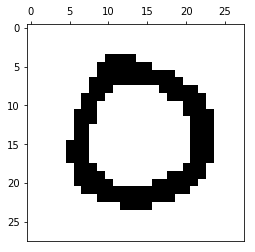

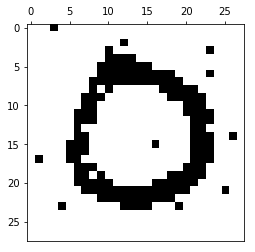

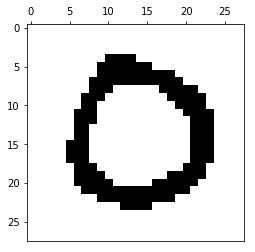

In [20]:
show(zipped_s[0][1]) # most accurate training image
show(zipped_s[0][3]) # most accurate training image, noisy
show(zipped_s[0][0]) # most accurate reconstruction

#### Least accurate reconstruction

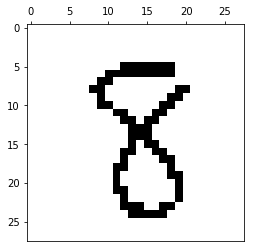

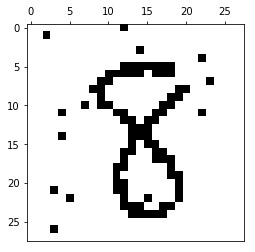

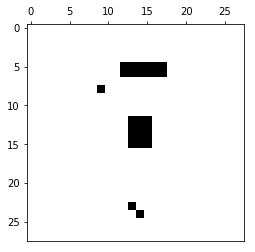

In [21]:
show(zipped_s[-1][1]) # least accurate training image
show(zipped_s[-1][3]) # least accurate training image, noisy
show(zipped_s[-1][0]) # least accurate reconstruction

## Receiver Operating Curves

In [22]:
roc_tpr = []
roc_fpr = []

for n in range(len(results_bin)):
    numCorrect = 0
    numFalse = 0
    numTrueBlack = 0
    numTrueWhite = 0
    for i in range(500):
        for j in range(28):
            for k in range(28):
                if training_binarized[i,j,k] == 1:
                    numTrueBlack += 1
                    if results_bin[n,i,j,k] == 1:
                        numCorrect += 1
                else:
                    numTrueWhite += 1
                    if results_bin[n,i,j,k] == 1:
                        numFalse += 1

    roc_tpr.append(float(numCorrect) / float(numTrueBlack))
    roc_fpr.append(float(numFalse) / float(numTrueWhite))

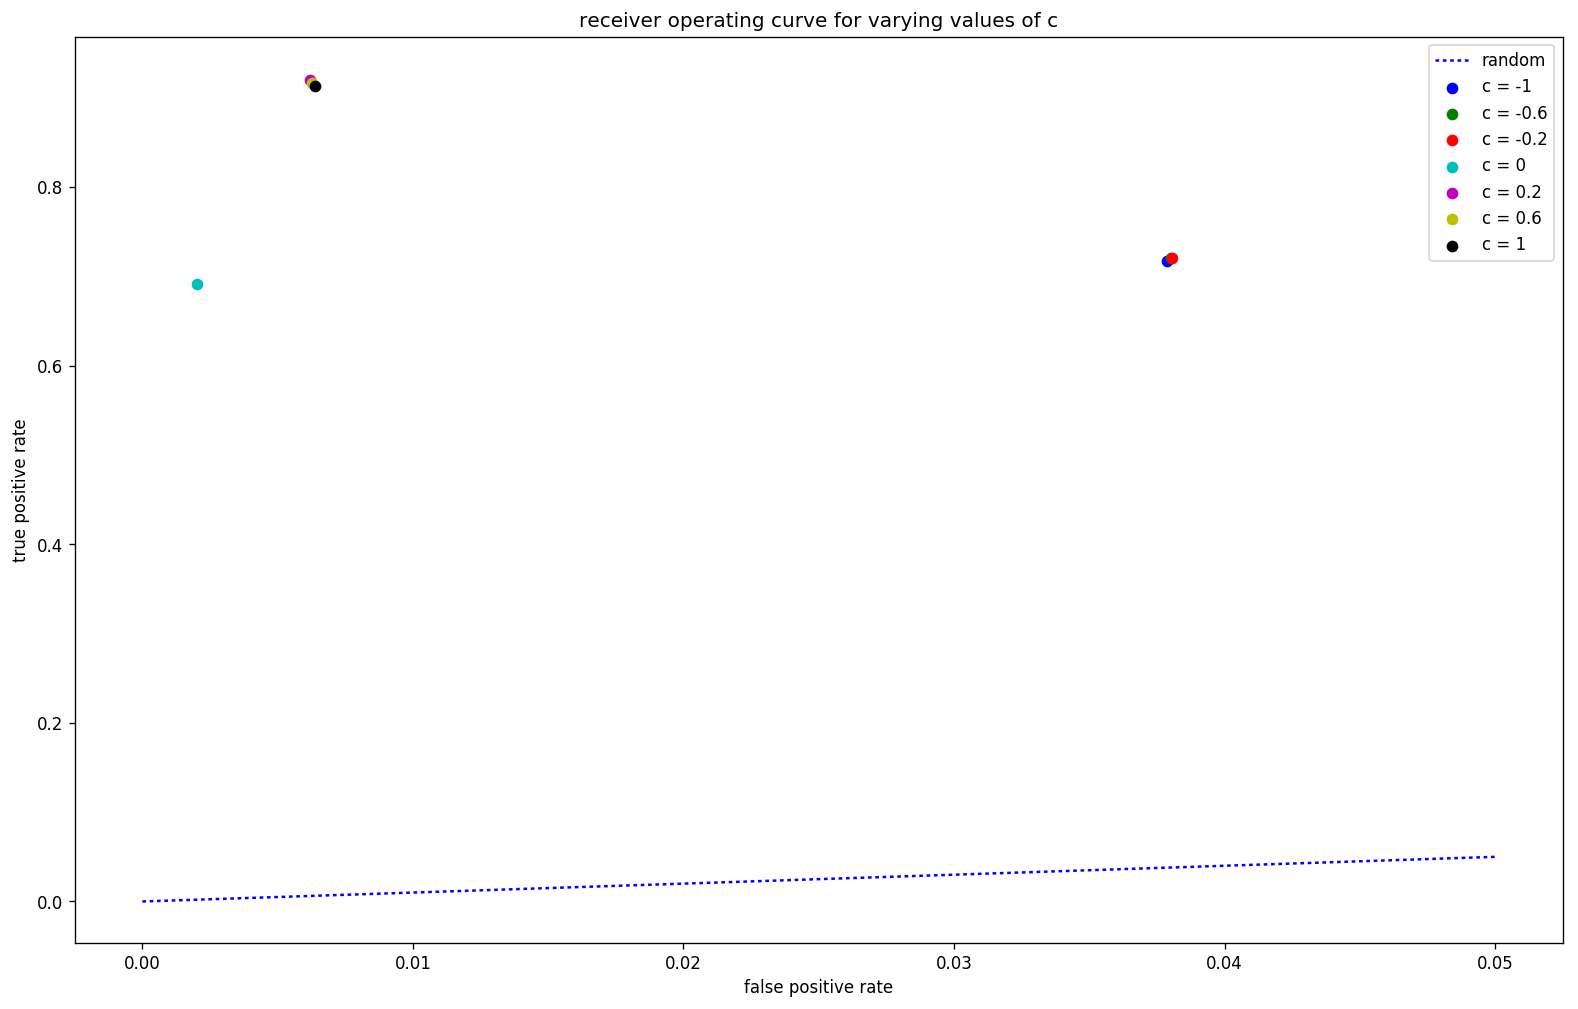

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10), dpi=120)
labels = ['c = -1','c = -0.6','c = -0.2','c = 0','c = 0.2','c = 0.6','c = 1']
colors = ['b','g','r','c','m','y','k']
plt.plot([0,.05],[0,.05], color='blue', linestyle='dotted', label='random')
a = []
for i,(x,y) in enumerate(zip(roc_fpr, roc_tpr)):
    a.append(plt.scatter(x,y,color=colors[i], label=labels[i]))

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve for varying values of c')
plt.show()

### Explanation

The ROC curve, visualized above, compares the false positive rate to the true positive rate. An ideal ROC curve approaches the top left corner of the chart which represents a perfect true positive rate (100%) and 0% false positive rate. We can see a cluster of c > 0 points at the top left, implying a high true positive and low false positive rate. The c < 0 points are clustered on the right, showing a high relative false positive rate and lower true positive rate (the green dot is behind the red dot). The lone c = 0 point has a low true positive rate but also a low false positive rate.

The dotted line is a worst-case scenario: that is, it represents the true and false positive rate of picking between black and white pixels randomly (line y=x). Anything above this line is considered accurate. Note the unequal axes.